# Tree segmentation with multitemporal Sentinel 1/2 imagery

## John Brandt
## February 2022

## Overview

This notebook contains the TensorFlow model training and prediction. The notebook uses tensorflow 1.15.1 and additionally relies on Keras.

## References

- DropBlock
- Zone out
- Stochastic weight averaging
- Sharpness aware minimization
- Surface loss
- Partial convolution
- Group normalization
- Swish activation
- Adabound
- Equibatch
- CutMix
- 


## Package Loading

In [1]:
from tqdm import tqdm_notebook, tnrange
import tensorflow as tf

sess = tf.Session()
from keras import backend as K
K.set_session(sess)

from time import sleep

import keras
from tensorflow.python.keras.layers import *
from tensorflow.python.keras.layers import ELU
from keras.losses import binary_crossentropy
from tensorflow.python.ops import array_ops
from tensorflow.python.keras.layers import Conv2D, Lambda, Dense, Multiply, Add
from tensorflow.initializers import glorot_normal, lecun_normal
from scipy.ndimage import median_filter
from skimage.transform import resize

import pandas as pd
import numpy as np
from random import shuffle
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import itertools
from tensorflow.contrib.framework import arg_scope
from keras.regularizers import l1
from tensorflow.layers import batch_normalization
from tensorflow.python.util import deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

os.environ['KMP_DUPLICATE_LIB_OK']='True'

Using TensorFlow backend.


## Utility scripts

In [2]:
%run ../src/layers/zoneout.py
%run ../src/layers/adabound.py
%run ../src/layers/convgru.py
%run ../src/layers/dropblock.py
%run ../src/layers/extra_layers.py
%run ../src/layers/stochastic_weight_averaging.py
%run ../src/preprocessing/indices.py
%run ../src/preprocessing/slope.py
#%run ../src/utils/metrics.py
#%run ../src/utils/lovasz.py

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




# Hyperparameter definitions

In [3]:
ZONE_OUT_PROB = 0.90
ACTIVATION_FUNCTION = 'swish'

INITIAL_LR = 1e-3
DROPBLOCK_MAXSIZE = 5

N_CONV_BLOCKS = 1
FINAL_ALPHA = 0.33
LABEL_SMOOTHING = 0.03

L2_REG = 0.
BATCH_SIZE = 32
MAX_DROPBLOCK = 0.6

FRESH_START = True
best_val = 0.2

START_EPOCH = 1
END_EPOCH = 100

n_bands = 17
initial_flt = 32
mid_flt = 32 * 2
high_flt = 32 * 2 * 2

temporal_model = True
input_size = 28
output_size = 14

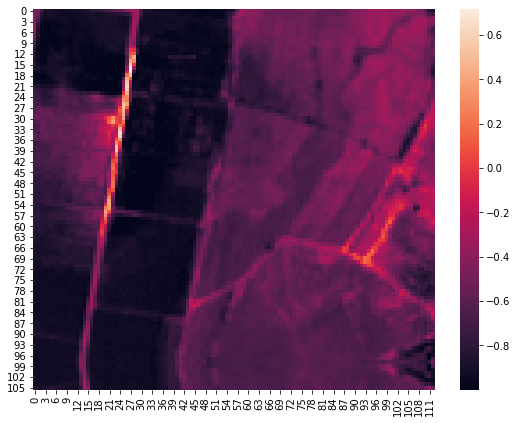

In [4]:
x = np.load("../src/subtile.npy")
from matplotlib import pyplot as plt
import seaborn as sns    

plt.figure(figsize=(9, 7))
sns.heatmap(x[0, 124:, 117:, 0])

(60, 13, 28, 28, 17)


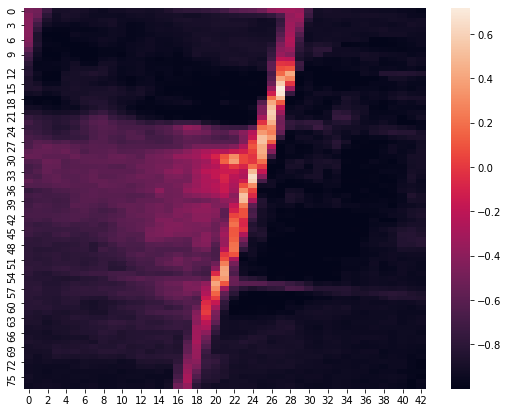

In [5]:
x = np.load("../src/subtile.npy")
from matplotlib import pyplot as plt
import seaborn as sns    

plt.figure(figsize=(9, 7))
sns.heatmap(x[0, 124:-28, 117:-70, 0])


starts = np.arange(124, 230-28, 8)
starts2 = np.arange(117, 230-70, 8)
xs = np.zeros((len(starts)*len(starts2), 13, 28, 28, 17), dtype = np.float32)
i = 0
for l in starts:
    for y in starts2:
        #print(l, y)
        xs[i] = x[:, l:l+28, y:y+28, :]
        i += 1
print(xs.shape)
ys = np.zeros((xs.shape[0], 14, 14))
np.save("pineapplex.npy", xs)
np.save("pineappley.npy", ys)

# Custom layer definitions

### Utility blocks (Batch norm, cSSE, etc.)

In [6]:
def sse_block(prevlayer, prefix):
    '''Spatial excitation and channel squeeze layer.
       Calculates a 1x1 convolution with sigmoid activation to create a 
       spatial map that is multiplied by the input layer

         Parameters:
          prevlayer (tf.Variable): input layer
          prefix (str): prefix for tensorflow scope

         Returns:
          x (tf.Variable): output of the sse_block
    '''
    conv = Conv2D(1, (1, 1), padding="same", kernel_initializer=tf.keras.initializers.he_normal(),
                  activation='sigmoid', strides=(1, 1),
                  name=prefix + "_conv")(prevlayer)
    conv = Multiply(name=prefix + "_mul")([prevlayer, conv])
    return conv


class ReflectionPadding2D(Layer):
    '''Adapted from https://github.com/mronta/CycleGAN-in-Keras/blob/master/reflection_padding.py
       This is used instead of zero padding where possible to reduce boundary artifacts
    '''
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        """ If you are using "channels_last" configuration"""
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')

### Conv GRU Block

In [7]:
def gru_block(inp, length, size, flt, scope, train, normalize = True):
    '''Bidirectional convolutional GRU block with 
       zoneout and CSSE blocks in each time step

         Parameters:
          inp (tf.Variable): (B, T, H, W, C) layer
          length (tf.Variable): (B, T) layer denoting number of
                                steps per sample
          size (int): kernel size of convolution
          flt (int): number of convolution filters
          scope (str): tensorflow variable scope
          train (tf.Bool): flag to differentiate between train/test ops
          normalize (bool): whether to compute layer normalization

         Returns:
          gru (tf.Variable): (B, H, W, flt*2) bi-gru output
          steps (tf.Variable): (B, T, H, W, flt*2) output of each step
    '''
    with tf.variable_scope(scope):
        print(f"GRU input shape {inp.shape}, zoneout: {ZONE_OUT_PROB}")
        
        # normalize is internal group normalization within the reset gate
        # sse is internal SSE block within the state cell

        cell_fw = ConvGRUCell(shape = size, filters = flt,
                           kernel = [3, 3], padding = 'VALID', 
                           normalize = normalize, sse = True)
        cell_bw = ConvGRUCell(shape = size, filters = flt,
                           kernel = [3, 3], padding = 'VALID',
                           normalize = normalize, sse = True)
        
        cell_fw = ZoneoutWrapper(
           cell_fw, zoneout_drop_prob = ZONE_OUT_PROB, is_training = train)
        cell_bw = ZoneoutWrapper(
            cell_bw, zoneout_drop_prob = ZONE_OUT_PROB, is_training = train)
        steps, out = convGRU(inp, cell_fw, cell_bw, length)
        gru = tf.concat(out, axis = -1)
        steps = tf.concat(steps, axis = -1)
        print(f"GRU block output shape {gru.shape}")
    return gru, steps

### Conv blocks

In [8]:
def partial_conv(x, channels, kernel=3, stride=1, use_bias=False, padding='SAME', scope='conv_0'):
    """Implementation of https://arxiv.org/abs/1804.07723
       Partial conv is used in place of "SAME" padding to reduce boundary artifacts
    """
    with tf.variable_scope(scope):
        if padding.lower() == 'SAME'.lower() :
            with tf.variable_scope('mask'):
                _, h, w, _ = x.get_shape().as_list()

                slide_window = kernel * kernel
                mask = tf.ones(shape=[1, h, w, 1])

                update_mask = tf.layers.conv2d(mask, filters=1,
                                               kernel_size=kernel,
                                               kernel_initializer=tf.constant_initializer(1.0),
                                               strides=stride, 
                                               padding=padding, 
                                               use_bias=False,
                                               trainable=False)

                mask_ratio = slide_window / (update_mask + 1e-8)
                update_mask = tf.clip_by_value(update_mask, 0.0, 1.0)
                mask_ratio = mask_ratio * update_mask

            with tf.variable_scope('x'):
                x = tf.layers.conv2d(x, filters=channels,
                                     kernel_size=kernel, 
                                     kernel_initializer=tf.keras.initializers.he_normal(),
                                     strides=stride,
                                     padding=padding, 
                                     use_bias=False)
                x = x * mask_ratio

                if use_bias:
                    bias = tf.get_variable("bias", 
                                           [channels],
                                           initializer=tf.constant_initializer(0.0))

                    x = tf.nn.bias_add(x, bias)
                    x = x * update_mask

        else :
            x = tf.layers.conv2d(x, filters=channels,
                                 kernel_size=kernel, 
                                 kernel_initializer=tf.keras.initializers.he_normal(),
                                 strides=stride,
                                 padding=padding,
                                 use_bias=use_bias)

        return x

def conv_swish_gn(inp, 
                 is_training, 
                 kernel_size,
                 scope,
                 filters, 
                 keep_rate,
                 stride = (1, 1),
                 activation = True,
                 use_bias = False,
                 norm = True,
                 dropblock = True,
                 csse = True,
                 weight_decay = None,
                 block_size = 5,
                 padding = "SAME",
                 partial = True):
    '''2D convolution, group normalization, SWISH activation, drop block, SSE. 
       DropBlock performs best when applied last, according to original paper.
       This is the core CONV block for this model.

         Parameters:
          inp (tf.Variable): input layer
          is_training (str): flag to differentiate between train/test ops
          kernel_size (int): size of convolution
          scope (str): tensorflow variable scope
          filters (int): number of filters for convolution
          keep_rate (float): Keep rate for dropblock
          stride (tuple): Conv2D stride parameter
          activation (bool): Whether or not to apply Swish activation
          use_bias (bool): whether to use bias. Should always be false
          norm (bool): whether or not to apply group normalization
          dropblock (bool): whether or not to apply dropblock
          csse (bool): whether or not to apply SSE block
          weight_decay (bool): not currently implemented
          block_size (int): Block size for dropblock
          padding (str): padding parameter for conv2d
          partial (bool): Whether or not to use partial conv or Conv2D

         Returns:
          conv (tf.Variable): output of the block
        
         References:
          http://papers.nips.cc/paper/8271-dropblock-a-regularization-
              method-for-convolutional-networks.pdf
          https://arxiv.org/abs/1702.03275
          
    '''
    
    gn_flag = "Group Norm" if norm else ""
    activation_flag = "RELU" if activation else "Linear"
    sse_flag = "SSE" if csse else "No SSE"
    bias_flag = "Bias" if use_bias else "NoBias"
    drop_flag = "DropBlock" if dropblock else "NoDrop"
        
    print(f"{scope} Conv: Kernel: {kernel_size}, {gn_flag}, {activation_flag}, {sse_flag}, {drop_flag}")

    with tf.variable_scope(scope + "_conv"):
        if not partial:
            conv = Conv2D(filters = filters, 
                          kernel_size = (kernel_size, kernel_size), 
                          strides = stride,
                          activation = None,
                          padding = 'valid',
                          use_bias = use_bias,
                          kernel_initializer = tf.keras.initializers.he_normal()
                         )(inp)
        if partial:
            conv = partial_conv(inp, filters,
                                kernel=kernel_size, 
                                stride=1, 
                                use_bias=False,
                                padding=padding, 
                                scope = scope)
    if activation:
        conv = tf.nn.swish(conv)
    if norm:
        conv = group_norm(x = conv, scope = scope, G = 8)
    if csse:
        conv = sse_block(conv, "csse_" + scope)
    if dropblock: 
        with tf.variable_scope(scope + "_drop"):
            drop_block = DropBlock2D(keep_prob=keep_rate, block_size= block_size)
            conv = drop_block(conv, is_training)
    return conv

# Model definition

## Placeholders

In [9]:
reg = tf.contrib.layers.l2_regularizer(0.)
temporal_model = True
input_size = 28
n_bands = 17
output_size = 14

if temporal_model:
    inp = tf.placeholder(tf.float32, shape=(None, 13, input_size, input_size, n_bands))
    length = tf.placeholder_with_default(np.full((1,), 12), shape = (None,))
else:
    inp = tf.placeholder(tf.float32, shape=(None, input_size, input_size, n_bands))
    
labels = tf.placeholder(tf.float32, shape=(None, output_size, output_size))#, 1))
keep_rate = tf.placeholder_with_default(1.0, ()) # For DropBlock
is_training = tf.placeholder_with_default(False, (), 'is_training') # For DropBlock
alpha = tf.placeholder(tf.float32, shape = ()) # For loss scheduling
ft_lr = tf.placeholder_with_default(0.001, shape = ()) # For loss scheduling
loss_weight = tf.placeholder_with_default(1.0, shape = ())
beta_ = tf.placeholder_with_default(0.0, shape = ()) # For loss scheduling, not currently implemented

INFO:tensorflow:Scale of 0 disables regularizer.


## Layers

## Model

The model uses a UNet architecture where the encoder extracts increasingly abstract features and the decoder upsamples the features to the target resolution.

The encoder consists of three blocks:

- GRU: A bidirectional convolutional GRU with channel squeeze and spatial excitation, and group normalization, extracts 3x3 features from the multitemporal imagery
- Conv1: A MaxPool-conv-swish-groupNorm-csse layer takes the output of the GRU (size 28) and reduces to size 12
- Conv2: The output of the MaxPool-conv-swish-csse-DropBlock is a 4x4x128 encoded feature map

The decoder consists of two blocks:

- Upconv1: upsample-conv-swish-csse-concat-conv-swish
- Upconv2: upsample-conv-swish-csse-concat-conv-swish
- Output sigmoid


In [10]:
# master modmel is 32, 64, 96, 230k paramms
initial_flt = 32
mid_flt = 32 * 2
high_flt = 32 * 2 * 2
INPUT_SIZE = 28
SIZE_X = 28

#inp = ReflectionPadding5D((1, 1))(inp)
gru_input = inp[:, :12, ...]
gru, steps = gru_block(inp = gru_input, length = length,
                            size = [INPUT_SIZE, SIZE_X, ], # + 2 here for refleclt pad
                            flt = initial_flt // 2,
                            scope = 'down_16',
                            train = is_training)
with tf.variable_scope("gru_drop"):
    drop_block = DropBlock2D(keep_prob=keep_rate, block_size=4)
    gru = drop_block(gru, is_training)
    
# Median conv
median_input = inp[:, -1, ...]
median_conv = conv_swish_gn(inp = median_input, is_training = is_training, stride = (1, 1),
            kernel_size = 3, scope = 'conv_median', filters = initial_flt, 
            keep_rate = keep_rate, activation = True, use_bias = False, norm = True,
            csse = True, dropblock = True, weight_decay = None)

print(f"Median conv: {median_conv.shape}")

concat1 = tf.concat([gru, median_conv], axis = -1)
concat = conv_swish_gn(inp = concat1, is_training = is_training, stride = (1, 1),
            kernel_size = 3, scope = 'conv_concat', filters = initial_flt,
            keep_rate = keep_rate, activation = True, use_bias = False, norm = True,
            csse = True, dropblock = True, weight_decay = None, padding = "SAME")
print(f"Concat: {concat.shape}")

    
# MaxPool-conv-swish-GroupNorm-csse
pool1 = MaxPool2D()(concat)
conv1 = conv_swish_gn(inp = pool1, is_training = is_training, stride = (1, 1),
            kernel_size = 3, scope = 'conv1', filters = mid_flt,
            keep_rate = keep_rate, activation = True, use_bias = False, norm = True, padding = "VALID",
            csse = True, dropblock = True, weight_decay = None)
print(f"Conv1: {conv1.shape}")

# MaxPool-conv-swish-csse-DropBlock
pool2 = MaxPool2D()(conv1)
conv2 = conv_swish_gn(inp = pool2, is_training = is_training, stride = (1, 1),
            kernel_size = 3, scope = 'conv2', filters = high_flt, 
            keep_rate = keep_rate, activation = True, use_bias = False, norm = True,
            csse = True, dropblock = True, weight_decay = None, block_size = 4, padding = "VALID")
print("Encoded", conv2.shape)

# Decoder 4 - 8, upsample-conv-swish-csse-concat-conv-swish
up2 = tf.keras.layers.UpSampling2D((2, 2), interpolation = 'nearest')(conv2)
#up2 = ReflectionPadding2D((1, 1,))(up2)
up2 = conv_swish_gn(inp = up2, is_training = is_training, stride = (1, 1),
                    kernel_size = 3, scope = 'up2', filters = mid_flt, 
                    keep_rate = keep_rate, activation = True, use_bias = False, norm = True,
                    csse = True, dropblock = True, weight_decay = None)
conv1_crop = Cropping2D(2)(conv1)
print(conv1_crop.shape)
up2 = tf.concat([up2, conv1_crop], -1)
#up2 = ReflectionPadding2D((1, 1,))(up2)
up2 = conv_swish_gn(inp = up2, is_training = is_training, stride = (1, 1),
                    kernel_size = 3, scope = 'up2_out', filters = mid_flt, 
                    keep_rate =  keep_rate, activation = True, use_bias = False, norm = True,
                    csse = True, dropblock = True, weight_decay = None)

# Decoder 8 - 14 upsample-conv-swish-csse-concat-conv-swish
up3 = tf.keras.layers.UpSampling2D((2, 2), interpolation = 'nearest')(up2)
#up3 = ReflectionPadding2D((1, 1,))(up3)
up3 = conv_swish_gn(inp = up3, is_training = is_training, stride = (1, 1),
                    kernel_size = 3, scope = 'up3', filters = initial_flt, 
                    keep_rate = keep_rate, activation = True, use_bias = False, norm = True,
                    csse = True, dropblock = True, weight_decay = None)
gru_crop = Cropping2D(6)(concat)
print(up3.shape)
print(gru_crop.shape)
up3 = tf.concat([up3, gru_crop], -1)

up3 = conv_swish_gn(inp = up3, is_training = is_training, stride = (1, 1),
                    kernel_size = 3, scope = 'out', filters = initial_flt, 
                    keep_rate  = keep_rate, activation = True, use_bias = False, norm = True,
                    csse = True, dropblock = False, weight_decay = None, padding = "VALID")


#print("Initializing last sigmoid bias with -2.94 constant")
init = tf.constant_initializer([-np.log(0.7/0.3)]) # For focal loss
print(f"The output is {up2.shape}, with a receptive field of {1}")
fm = Conv2D(filters = 1,
            kernel_size = (1, 1),
            padding = 'valid',
            activation = 'sigmoid',
            bias_initializer = init,
           )(up3) # For focal loss
#fm = Cropping2D(1)(fm)

print(f"The output, sigmoid is {fm.shape}, with a receptive field of {1}")

GRU input shape (?, 12, 28, 28, 17), zoneout: 0.9

(3, 3, 33, 32)
(3, 3, 33, 32)
GRU block output shape (?, 28, 28, 32)


conv_median Conv: Kernel: 3, Group Norm, RELU, SSE, DropBlock
Median conv: (?, 28, 28, 32)
conv_concat Conv: Kernel: 3, Group Norm, RELU, SSE, DropBlock
Concat: (?, 28, 28, 32)
conv1 Conv: Kernel: 3, Group Norm, RELU, SSE, DropBlock
Conv1: (?, 12, 12, 64)
conv2 Conv: Kernel: 3, Group Norm, RELU, SSE, DropBlock
Encoded (?, 4, 4, 128)
up2 Conv: Kernel: 3, Group Norm, RELU, SSE, DropBlock
(?, 8, 8, 64)
up2_out Conv: Kernel: 3, Group Norm, RELU, SSE, DropBlock
up3 Conv: Kernel: 3, Group Norm, RELU, SSE, DropBlock
(?, 16, 16, 32)
(?, 16, 16, 32)
out Conv: Kernel: 3, Group Norm, RELU, SSE, NoDrop
The output is (?, 8, 8, 64), with a receptive field of 1
The output, sigmoid is (?, 14, 14, 1), with a receptive field of 1


In [11]:
finetune_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "csse_out") + \
                tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "out")+ \
                tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"conv2d_13") + \
                tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "up3") + \
                tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "up3_drop") + \
                tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "csse_up3") + \
                tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "up2_out") + \
                tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "up2_out_drop") + \
                tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "csse_up2_out") + \
                tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "up2") + \
                tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "up2_drop") + \
                tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "csse_up2")

In [12]:
finetune_vars

[<tf.Variable 'csse_out_conv/kernel:0' shape=(1, 1, 32, 1) dtype=float32>,
 <tf.Variable 'csse_out_conv/bias:0' shape=(1,) dtype=float32>,
 <tf.Variable 'out_conv/out/conv2d/kernel:0' shape=(3, 3, 64, 32) dtype=float32_ref>,
 <tf.Variable 'out_norm/gamma_out:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'out_norm/beta_out:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'conv2d_13/kernel:0' shape=(1, 1, 32, 1) dtype=float32>,
 <tf.Variable 'conv2d_13/bias:0' shape=(1,) dtype=float32>,
 <tf.Variable 'up3_conv/up3/x/conv2d/kernel:0' shape=(3, 3, 64, 32) dtype=float32_ref>,
 <tf.Variable 'up3_norm/gamma_up3:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'up3_norm/beta_up3:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'csse_up3_conv/kernel:0' shape=(1, 1, 32, 1) dtype=float32>,
 <tf.Variable 'csse_up3_conv/bias:0' shape=(1,) dtype=float32>,
 <tf.Variable 'up2_out_conv/up2_out/x/conv2d/kernel:0' shape=(3, 3, 128, 64) dtype=float32_ref>,
 <tf.Variable 'up2_out_norm/gamma_up2_out:0' s

In [13]:
total_parameters = 0
for variable in tf.trainable_variables():
    shape = variable.get_shape()
    variable_parameters = 1
    for dim in shape:
        variable_parameters *= dim.value
    total_parameters += variable_parameters
print(f"This model has {total_parameters} parameters")

This model has 329929 parameters


In [14]:
from keras.losses import binary_crossentropy
import math
from scipy.ndimage import distance_transform_edt as distance

def weighted_bce_loss(y_true, y_pred, weight, mask = True, smooth = 0.03):
    '''Calculates the weighted binary cross entropy loss between y_true and
       y_pred with optional masking and smoothing for regularization
       
       For smoothing, we want to weight false positives as less important than
       false negatives, so we smooth false negatives 2x as much. 
    
         Parameters:
          y_true (arr):
          y_pred (arr):
          weight (float):
          mask (arr): DEPRECATED
          smooth (float):

         Returns:
          loss (float):
    '''
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    y_true = K.clip(y_true, smooth, 1. - smooth)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = tf.nn.weighted_cross_entropy_with_logits(
        y_true,
        logit_y_pred,
        weight,
    )

    return loss


def calc_dist_map(seg):
    
    """
    This is a modified version of surface loss to reduce
    the loss importance of samples at the boundary. THe original
    paper specifies a boundary loss of 0, but the low-resolution of
    Sentinel data requires some amount of boundary importance, and
    this function works well to accomplish that task
    """

    res = np.zeros_like(seg)
    posmask = seg.astype(np.bool)

    mults = np.ones_like(seg)
    ones = np.ones_like(seg)
    for x in range(1, res.shape[0] -1 ):
        for y in range(1, res.shape[0] - 1):
            # If > 1 px distance, double the weight of the positive
            # If == 1 px, half the weight of the negative
            # This is important because the calc_mask fn
            # leaves borders with 0 weight otherwise
            if seg[x, y] == 1:
                l = seg[x - 1, y]
                r = seg[x + 1, y]
                u = seg[x, y + 1]
                d = seg[x, y - 1]
                lu = seg[x - 1, y + 1]
                ru = seg[x + 1, y + 1]
                rd = seg[x + 1, y - 1]
                ld = seg[x -1, y - 1]
                
                sums = (l + r + u + d)
                sums2 = (l + r + u + d + lu + ru +rd + ld)
                if sums >= 2:
                    mults[x, y] = 2
                if sums2 <= 1:
                    ones[x - 1, y] = 0.5
                    ones[x + 1, y] = 0.5
                    ones[x, y + 1] = 0.5
                    ones[x, y - 1] = 0.5
                    ones[x - 1, y + 1] = 0.5
                    ones[x + 1, y + 1] = 0.5
                    ones[x + 1, y - 1] = 0.5
                    ones[x -1, y - 1] = 0.5

    if posmask.any():
        negmask = ~posmask
        res = distance(negmask) * negmask - (distance(posmask) - 1) * posmask
        # When % = 1, 0 -> 1.75
        # When % = 100, 0 -> 0
        res = np.round(res, 0)
        res[np.where(np.isclose(res, -.41421356, rtol = 1e-2))] = -1
        res[np.where(res == -1)] = -1 * mults[np.where(res == -1)]
        res[np.where(res == 0)] = -1  * mults[np.where(res == 0)]
        # When % = 1, 1 -> 0
        # When % = 100, 1 -> 1.75
        res[np.where(res == 1)] = 1 * ones[np.where(res == 1)]
        res[np.where(res == 1)] *= 0.67
        
    # Empirically capping the loss at -3 to 3 is better
    res[np.where(res < -3)] = -3
    res[np.where(res > 3)] = 3
    if np.sum(seg) == 196:
        res = np.ones_like(seg)
        res *= -1
    if np.sum(seg) == 0:
        res = np.ones_like(seg)
    return res


def calc_dist_map_batch(y_true):
    '''Applies calc_dist_map to each sample in an input batch
    
         Parameters:
          y_true (arr):
          
         Returns:
          loss (arr):
    '''
    y_true_numpy = y_true.numpy()
    return np.array([calc_dist_map(y)
                     for y in y_true_numpy]).astype(np.float32)


def surface_loss(y_true, y_pred):
    '''Calculates the mean surface loss for the input batch
       by multiplying the distance map by y_pred
    
         Parameters:
          y_true (arr):
          y_pred (arr):
          
         Returns:
          loss (arr):
        
         References:
          https://arxiv.org/abs/1812.07032
    '''
    y_true_dist_map = tf.py_function(func=calc_dist_map_batch,
                                     inp=[y_true],
                                     Tout=tf.float32)
    y_true_dist_map = tf.stack(y_true_dist_map, axis = 0)
    multipled = y_pred * y_true_dist_map
    loss = tf.reduce_mean(multipled, axis = (1, 2, 3))
    return loss


def bce_surface_loss(y_true, y_pred, alpha, weight, beta):
    
    """ Combines surface loss and binary cross entropy with a 
    alpha weighting factor. Beta is currently deprecated."""
    
    bce = weighted_bce_loss(y_true = y_true, 
                             y_pred = y_pred, 
                             weight = weight,
                             smooth = 0.03)

    bce = tf.reduce_mean(bce, axis = (1, 2, 3))
    surface = surface_loss(y_true, y_pred)
    surface = tf.reduce_mean(surface)

    bce = tf.reduce_mean(bce)
    bce = (1 - alpha) * bce
    surface_portion = alpha * surface
    result = bce + surface_portion
    return result

In [15]:
def grad_norm(gradients):
        norm = tf.compat.v1.norm(
            tf.stack([
                tf.compat.v1.norm(grad) for grad in gradients if grad is not None
            ])
        )
        return norm

FRESH_START = True
print(f"Starting model with: \n {ZONE_OUT_PROB} zone out \n {L2_REG} l2 \n"
      f"{INITIAL_LR} initial LR \n {total_parameters} parameters")  

if FRESH_START:
    # We use the Adabound optimizer
    optimizer = AdaBoundOptimizer(INITIAL_LR, ft_lr)
    train_loss = bce_surface_loss(tf.reshape(labels, (-1, 14, 14, 1)), 
                             fm, weight = loss_weight, 
                             alpha = alpha, beta = beta_)
    
    # If there is any L2 regularization, add it. Current model does not use
    l2_loss = tf.losses.get_regularization_loss()
    if len(tf.losses.get_regularization_losses()) > 0:
        train_loss = train_loss + l2_loss
        
    # If necessary to switch to SGD at any point, make that optimizer here
    #ft_optimizer = tf.train.MomentumOptimizer(ft_lr, momentum = 0.8, use_nesterov = True)
    
    
    test_loss = bce_surface_loss(tf.reshape(labels, (-1, 14, 14, 1)),
                            fm, weight = loss_weight, 
                            alpha = alpha, beta = beta_)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    with tf.control_dependencies(update_ops):
        train_op = optimizer.minimize(train_loss)   
        #ft_op = ft_optimizer.minimize(train_loss)
    
    # The following code blocks are for sharpness aware minimization
    # Adapted from https://github.com/sayakpaul/Sharpness-Aware-Minimization-TensorFlow
    # For tensorflow 1.15
    trainable_params = tf.trainable_variables()
    gradients = optimizer.compute_gradients(loss=train_loss, var_list=None)
    gradient_norm = grad_norm(gradients)
    scale = 0.05 / (gradient_norm + 1e-12)
    e_ws = []
    for (grad, param) in gradients:
        e_w = grad * scale
        param.assign_add(e_w)
        e_ws.append(e_w)

    sam_gradients = optimizer.compute_gradients(loss=train_loss, var_list=None)
    for (param, e_w) in zip(trainable_params, e_ws):
        param.assign_sub(e_w)
    train_step = optimizer.apply_gradients(sam_gradients)
    
    # Create a saver to save the model each epoch
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    saver = tf.train.Saver(max_to_keep = 150)

Starting model with: 
 0.9 zone out 
 0.0 l2 
0.001 initial LR 
 329929 parameters


In [16]:
FRESH_START = False
model_path  = "../models/may-avg-small/"
saver = tf.train.Saver(max_to_keep = 150)
if not os.path.exists(model_path):
    os.makedirs(model_path)
if os.path.isfile(f"{model_path}metrics.npy"):
    metrics = np.load(f"{model_path}metrics.npy")
    print(f"Loading {model_path}metrics.npy")
else:
    print("Starting anew")
    metrics = np.zeros((6, 300))

if not FRESH_START:
    path = model_path
    saver.restore(sess, tf.train.latest_checkpoint(path))

Starting anew
INFO:tensorflow:Restoring parameters from ../models/may-avg-small/-0


In [17]:
def initialize_uninitialized(sess):
    global_vars = tf.global_variables()
    is_not_initialized = sess.run([tf.is_variable_initialized(var) for var in global_vars])
    not_initialized_vars = [v for (v, f) in zip(global_vars, is_not_initialized) if not f]

    if len(not_initialized_vars):
        sess.run(tf.variables_initializer(not_initialized_vars))


ft_optimizer = tf.train.MomentumOptimizer(ft_lr, momentum = 0.8, use_nesterov = True)
train_loss = bce_surface_loss(tf.reshape(labels, (-1, 14, 14, 1)), 
                             fm, weight = loss_weight, 
                             alpha = alpha, beta = beta_)
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
with tf.control_dependencies(update_ops):
    #train_op = optimizer.minimize(train_loss)   
    ft_op = ft_optimizer.minimize(train_loss, var_list = finetune_vars)
"""
trainable_params = tf.trainable_variables()
gradients = ft_optimizer.compute_gradients(loss=train_loss, var_list=None)
gradient_norm = grad_norm(gradients)
scale = 0.05 / (gradient_norm + 1e-12)
e_ws = []
for (grad, param) in gradients:
    e_w = grad * scale
    param.assign_add(e_w)
    e_ws.append(e_w)

sam_gradients = ft_optimizer.compute_gradients(loss=train_loss, var_list=None)
for (param, e_w) in zip(trainable_params, e_ws):
    param.assign_sub(e_w)
train_step_ft = ft_optimizer.apply_gradients(sam_gradients)
"""
initialize_uninitialized(sess)


In [18]:
# Implementation of stochastic weight averaging

        
model_vars = tf.trainable_variables()
swa = StochasticWeightAveraging()
swa_op = swa.apply(var_list=model_vars)
with tf.variable_scope('BackupVariables'):
    # force tensorflow to keep theese new variables on the CPU ! 
    backup_vars = [tf.get_variable(var.op.name, dtype=var.value().dtype, trainable=False,
                                   initializer=var.initialized_value())
                   for var in model_vars]

# operation to assign SWA weights to model
swa_to_weights = tf.group(*(tf.assign(var, swa.average(var).read_value()) for var in model_vars))
# operation to store model into backup variables
save_weight_backups = tf.group(*(tf.assign(bck, var.read_value()) for var, bck in zip(model_vars, backup_vars)))
# operation to get back values from backup variables to model
restore_weight_backups = tf.group(*(tf.assign(var, bck.read_value()) for var, bck in zip(model_vars, backup_vars)))

initialize_uninitialized(sess)

# Data loading

*  Load in CSV data from Collect Earth
*  Reconstruct the X, Y grid for the Y data per sample
*  Calculate remote sensing indices
*  Stack X, Y, length data
*  Apply median filter to DEM

In [16]:
import hickle as hkl
normalize = False
"""
train_x = hkl.load("../data/test/test_x.hkl")
train_y = hkl.load("../data/test/test_y.hkl")
data = pd.read_csv("../data/test/test_plot_ids.csv")
print(train_x.shape)

outliers = [2, 3, 4, 17, 29, 37, 41, 42, 59, 62, 101, 109, 120, 125, 161, 165, 174, 189, 
            213, 216, 225, 244, 253, 255, 256, 268, 282, 306, 307, 308, 322, 328, 332, 
            333, 340, 342, 343, 344, 348, 349, 365, 366, 375, 377, 378, 380, 381, 383,
            384, 385, 386, 388, 389, 390, 393, 397, 407, 428, 440, 441, 443, 444, 445, 
            447, 449, 451, 452, 469, 470, 471, 474, 476, 478, 481, 482, 491, 495, 502, 
            504, 513, 518, 521, 527, 532, 548, 558, 565, 567, 568, 569, 575, 578, 580, 
            582, 588, 591, 592, 594, 598, 607, 613, 616, 618, 622, 624, 632, 636, 637,
            638, 651, 656, 685, 713, 733, 737, 740, 750, 752, 766, 779, 783, 795, 813,
            832, 839, 840, 844, 851, 875, 876, 878, 879, 885, 886, 888, 889, 892, 898,
            920, 921, 922, 923, 946, 950, 953, 978, 1000, 1018, 1027, 1033, 1048, 1049,
            1053, 1059, 1061, 1063, 1079, 1089, 1090, 1092, 1096, 1099, 1101, 1105, 1125,
            1140, 1167, 1170, 1173, 1176, 1183, 1194, 1198, 1206, 1213, 1217, 1228, 1229, 1237, 1238, 1242, 
            1271, 1275, 1279, 1327, 1348, 1355, 1361, 1362, 1381, 1387, 1392, 1393, 1397, 1419]

train_x = np.delete(train_x, np.array(outliers), 0)
train_y = np.delete(train_y, np.array(outliers), 0)

"""
train_x = hkl.load("../data/train/train_x.hkl")
train_y = hkl.load("../data/train/train_y.hkl")
data = pd.read_csv("../data/train/train_plot_ids.csv")

"""
train_x = np.concatenate([train_x, train_x2], axis = 0)
train_y = np.concatenate([train_y, train_y2], axis = 0)
"""
if not isinstance(train_x.flat[0], np.floating):
    assert np.max(train_x) > 1
    train_x = train_x / 65535.

# In our training data, index 11 specified the date of the imagery
# Which lead to overfitting, so it is removed here
train_x = np.delete(train_x, 11, -1)

In [17]:
def convert_to_db(x, min_db):
    """Converts sigma backscatter to decibel"""
    x = 10 * np.log10(x + 1/65535)
    x[x < -min_db] = -min_db
    x = x + min_db
    x = x / min_db
    x = np.clip(x, 0, 1)
    return x


def grndvi(array):
    nir = np.clip(array[..., 3], 0, 1)
    green = np.clip(array[..., 1], 0, 1)
    red = np.clip(array[..., 2], 0, 1)
    denominator = (nir+(green+red)) + 1e-5
    return (nir-(green+red)) / denominator


def evi(x: np.ndarray, verbose: bool = False) -> np.ndarray:
    '''
    Calculates the enhanced vegetation index
    2.5 x (08 - 04) / (08 + 6 * 04 - 7.5 * 02 + 1)
    '''

    BLUE = x[..., 0]
    GREEN = x[..., 1]
    RED = x[..., 2]
    NIR = x[..., 3]
    evis = 2.5 * ( (NIR-RED) / (NIR + (6*RED) - (7.5*BLUE) + 1))
    evis = np.clip(evis, -1.5, 1.5)
    return evis


def msavi2(x: np.ndarray, verbose: bool = False) -> np.ndarray:
    '''
    Calculates the modified soil-adjusted vegetation index 2
    (2 * NIR + 1 - sqrt((2*NIR + 1)^2 - 8*(NIR-RED)) / 2
    '''
    BLUE = x[..., 0]
    GREEN = x[..., 1]
    RED = np.clip(x[..., 2], 0, 1)
    NIR = np.clip(x[..., 3], 0, 1)

    msavis = (2 * NIR + 1 - np.sqrt( (2*NIR+1)**2 - 8*(NIR-RED) )) / 2
    return msavis


def bi(x: np.ndarray, verbose: bool = False) -> np.ndarray:
    """Bare soil index"""
    B11 = np.clip(x[..., 8], 0, 1)
    B4 = np.clip(x[..., 2], 0, 1)
    B8 = np.clip(x[..., 3], 0, 1)
    B2 = np.clip(x[..., 0], 0, 1)
    bis = ((B11 + B4) - (B8 + B2)) / ((B11 + B4) + (B8 + B2))
    return bis

In [18]:
train_x[..., -1] = convert_to_db(train_x[..., -1], 22)
train_x[..., -2] = convert_to_db(train_x[..., -2], 22)

indices = np.empty((train_x.shape[0], 12, 28, 28, 4))
indices[..., 0] = evi(train_x)
indices[..., 1] = bi(train_x)
indices[..., 2] = msavi2(train_x)
indices[..., 3] = grndvi(train_x)

train_x = np.concatenate([train_x, indices], axis = -1)
med = np.median(train_x, axis = 1)
med = med[:, np.newaxis, :, :, :]
train_x = np.concatenate([train_x, med], axis = 1)

In [19]:
np.save("../data/train/train_x.npy", train_x)
np.save("../data/train/train_y.npy", train_y)

## Standardization

In [22]:
min_all = [0.006576638437476157, 0.0162050812542916, 0.010040436408026246, 
           0.013351644159609368, 0.01965362020294499, 0.014229037918669413, 
           0.015289539940489814, 0.011993591210803388, 0.008239871824216068, 
           0.006546120393682765, 0.0, 0.0, 0.0, -0.1409399364817101, 
           -0.4973397113668104, -0.09731556326714398, -0.7193834232943873]

max_all = [0.2691233691920348, 0.3740291447318227, 0.5171435111009385, 0.6027466239414053,
           0.5650263218127718, 0.5747005416952773, 0.5933928435187305, 0.6034943160143434, 
           0.7472037842374304, 0.7000076295109483, 0.509269855802243, 0.948334642387533, 
           0.6729257769285485, 0.8177635298774327, 0.35768999002433816, 0.7545951919107605, 
           0.7602693339366691]

# Min all, and max all are the 0.1 and 99.9 percentiles of each band
for band in tnrange(0, train_x.shape[-1]):
    mins = min_all[band]
    maxs = max_all[band]
    train_x[..., band] = np.clip(train_x[..., band], mins, maxs)
    midrange = (maxs + mins) / 2
    rng = maxs - mins
    standardized = (train_x[..., band] - midrange) / (rng / 2)
    train_x[..., band] = standardized

/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  


  0%|          | 0/17 [00:00<?, ?it/s]

## Load and process test data

In [23]:
import hickle as hkl
test_x = hkl.load("../data/train/train_x.hkl")
test_y = hkl.load("../data/train/train_y.hkl")
test_data = pd.read_csv("../data/train/train_plot_ids.csv")

test_x = np.delete(test_x, 11, -1)

if not isinstance(test_x.flat[0], np.floating):
    assert np.max(test_x) > 1
    test_x = test_x / 65535.
    
test_x[..., -1] = convert_to_db(test_x[..., -1], 22)
test_x[..., -2] = convert_to_db(test_x[..., -2], 22)

indices = np.empty((test_x.shape[0], 12, 28, 28, 4))
indices[..., 0] = evi(test_x)
indices[..., 1] = bi(test_x)
indices[..., 2] = msavi2(test_x)
indices[..., 3] = grndvi(test_x)

test_x = np.concatenate([test_x, indices], axis = -1)
med = np.median(test_x, axis = 1)
med = med[:, np.newaxis, :, :, :]
test_x = np.concatenate([test_x, med], axis = 1)

below_1 = [i for i, val in enumerate(test_x[..., :-2]) if np.min(val) < -1.66]
above_1 = [i for i, val in enumerate(test_x[..., :-2]) if np.max(val) > 1.66]
nans = [i for i, val in enumerate(test_x) if np.sum(np.isnan(val)) > 0]
outliers = below_1 + above_1 + nans
outliers = list(set(outliers))

print([x for x in test_data['plot_id'].iloc[outliers]])

test_x = np.delete(test_x, outliers, 0)
test_y = np.delete(test_y, outliers, 0)
test_data = test_data.drop(outliers, 0)
test_data = test_data.reset_index(drop = True)

[]


/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [24]:
for band in range(0, test_x.shape[-1]):
    mins = min_all[band]
    maxs = max_all[band]
    test_x[..., band] = np.clip(test_x[..., band], mins, maxs)
    midrange = (maxs + mins) / 2
    rng = maxs - mins
    standardized = (test_x[..., band] - midrange) / (rng / 2)
    test_x[..., band] = standardized

In [25]:
xs = np.load("pineapplex.npy")
ys = np.load('pineappley.npy')
#ys = np.zeros((24, 14, 14))
train_x = np.concatenate([train_x, xs], axis = 0)
train_y = np.concatenate([train_y, ys], axis = 0)

In [26]:
print(train_x.shape)

(112, 13, 28, 28, 17)


# Equibatch creation

The modelling approach uses equibatch sampling to ensure that there is a near constant standard deviation of the percent tree cover in the output labels for each batch. This helps ensure that the model performs equally well across gradients of tree cover, by mitigating the random possibility that many batches in a row near the end of sampling may be randomly biased towards a tree cover range.

It was actually very important for stable training to implement equibatch as the risk of diverging based on bad batches was very high without equibatch.

In [27]:
train_ids = [x for x in range(0, len(train_y))]

def multiplot(matrices):
    '''Plot multiple heatmaps with subplots
    
         Parameters:
          matrices (list of arrays):

         Returns:
          None
    '''
    fig, axs = plt.subplots(ncols=4)
    fig.set_size_inches(20, 4)
    for i, matrix in enumerate(matrices):
        sns.heatmap(data = matrix, ax = axs[i], vmin = 0, vmax = 0.9)
        axs[i].set_xlabel("")
        axs[i].set_ylabel("")
        axs[i].set_yticks([])
        axs[i].set_xticks([])

        
def equibatch(train_ids, p):
    '''Docstring
    
         Parameters:
          train_ids (list):
          p (list):

         Returns:
          equibatches (list):
    '''
    
    # Percents is the upper, lower bounds for each segment of equibatch
    percents = [9.0, 17.0, 27.0, 40.0, 63.0, 105.0, 158.0]

    train_ids_cp = (train_ids) + train_ids[-84:]#+ train_ids[-84:-60]#+ train_ids[-76:] + train_ids[-76:]
    np.random.shuffle(train_ids_cp)
    ix = train_ids_cp
    percs = [np.sum(x) for x in train_y[ix]]
    ids0 = [x for x, z in zip(ix, percs) if z <= 2]
    ids30 = [x for x, z in zip(ix, percs) if 2 < z <= percents[0]]
    ids40 = [x for x, z in zip(ix, percs) if percents[0] < z <= percents[1]]
    ids50 = [x for x, z in zip(ix, percs) if percents[1] < z <= percents[2]]
    ids60 = [x for x, z in zip(ix, percs) if percents[2] < z <= percents[3]]
    ids70 = [x for x, z in zip(ix, percs) if percents[3] < z <= percents[4]]
    ids80 = [x for x, z in zip(ix, percs) if percents[4] < z <= percents[5]]
    ids90 = [x for x, z in zip(ix, percs) if percents[5] < z <= percents[6]]
    ids100 = [x for x, z in zip(ix, percs) if percents[6] < z]
    
    new_batches = []
    maxes = [len(ids0), len(ids30), len(ids40), len(ids50), len(ids60), len(ids70),
             len(ids80), len(ids90), len(ids100)]
    
    # This essentially picks one of each segment of equibatch for each time
    # samples are appended to the shuffled training data batch
    cur_ids = [0] * len(maxes)
    iter_len = len(train_ids)//(len(maxes))
    for i in range(0, iter_len):
        for i, val in enumerate(cur_ids):
            if val > maxes[i] - 1:
                cur_ids[i] = 0
        if cur_ids[0] >= (maxes[0] - 2):
            cur_ids[0] = 0
        to_append = [ids0[cur_ids[0]],
                    ids30[cur_ids[1]], ids40[cur_ids[2]],
                    ids50[cur_ids[3]], ids60[cur_ids[4]], 
                    ids70[cur_ids[5]], ids80[cur_ids[6]],
                    ids90[cur_ids[7]], ids100[cur_ids[8]]]
        
        
        np.random.shuffle(to_append)
        new_batches.append(to_append)
        cur_ids = [x + 1 for x in cur_ids]
        
    new_batches = [item for sublist in new_batches for item in sublist]
    return new_batches

# Evaluation metrics

In [28]:
def compute_f1_score_at_tolerance(true, pred, tolerance = 1):
    """Because of coregistration errors, we evaluate the model
    where false positives/negatives must be >1px away from a true positive
    """
    fp = 0
    tp = 0
    fn = 0
    
    tp = np.zeros_like(true)
    fp = np.zeros_like(true)
    fn = np.zeros_like(true)
    
    for x in range(true.shape[0]):
        for y in range(true.shape[1]):
            min_x = np.max([0, x-1])
            min_y = np.max([0, y-1])
            max_y = np.min([true.shape[0], y+2])
            max_x = np.min([true.shape[0], x+2])
            if true[x, y] == 1:
                if np.sum(pred[min_x:max_x, min_y:max_y]) > 0:
                    tp[x, y] = 1
                else:
                    fn[x, y] = 1
            if pred[x, y] == 1:
                if np.sum(true[min_x:max_x, min_y:max_y]) > 0:
                    if true[x, y] == 1:
                        tp[x, y] = 1
                else:
                    fp[x, y] = 1                
                
    return np.sum(tp), np.sum(fp), np.sum(fn)

def calculate_metrics(al = 0.4, canopy_thresh = 100):
    '''Calculates the following metrics
       
         - Loss
         - F1
         - Precision
         - Recall
         - Dice
         - Mean surface distance
         - Average error
    
         Parameters:
          al (float):
          canopy_thresh (int)
          
         Returns:
          val_loss (float):
          best_dice (float):
          error (float):
    '''
    start_idx = 0
    stop_idx = len(test_x)
    best_f1, best_thresh, relaxed_f1 = 0, 0, 0
    preds, trues, vls = [], [], []

    test_ids = [x for x in range(len(test_x))]
    for test_sample in test_ids[start_idx:stop_idx]:
        if np.sum(test_y[test_sample]) < ((canopy_thresh/100) * 197):
            x_input = test_x[test_sample].reshape(1, 13, 28, 28, n_bands)
            x_median_input = calc_median_input(x_input)
            y, vl = sess.run([fm, test_loss], feed_dict={inp: x_input,
                                                          length: np.full((1,), 12),
                                                          is_training: False,
                                                          labels: test_y[test_sample].reshape(1, 14, 14),
                                                          loss_weight: 1.0,
                                                          alpha: 0.33,
                                                          })
            preds.append(y.reshape((14, 14)))
            vls.append(vl)
            trues.append(test_y[test_sample].reshape((14, 14)))
            
    # These threshes are just for ROC
    for thresh in range(7, 9):
        tps_relaxed = np.empty((len(preds), ))
        fps_relaxed = np.empty((len(preds), ))
        fns_relaxed = np.empty((len(preds), ))
        abs_error = np.empty((len(preds), ))
        
        for sample in range(len(preds)):
            pred = np.copy(preds[sample])
            true = trues[sample]
        
            pred[np.where(pred >= thresh*0.05)] = 1
            pred[np.where(pred < thresh*0.05)] = 0
            
            true_s = np.sum(true[1:-1])
            pred_s = np.sum(pred[1:-1])
            abs_error[sample] = abs(true_s - pred_s)
            tp_relaxed, fp_relaxed, fn_relaxed = compute_f1_score_at_tolerance(true, pred)
            tps_relaxed[sample] = tp_relaxed
            fps_relaxed[sample] = fp_relaxed
            fns_relaxed[sample] = fn_relaxed                   
            
        oa_error = np.mean(abs_error)
        precision_r = np.sum(tps_relaxed) / (np.sum(tps_relaxed) + np.sum(fps_relaxed))
        recall_r = np.sum(tps_relaxed) / (np.sum(tps_relaxed) + np.sum(fns_relaxed))
        f1_r = 2*((precision_r* recall_r) / (precision_r + recall_r))
        
        if f1_r > best_f1:
            best_f1 = f1_r
            p = precision_r
            r = recall_r
            error = oa_error
            best_thresh = thresh*0.05

    print(f"Val loss: {np.around(np.mean(vls), 3)}"
          f" Thresh: {np.around(best_thresh, 2)}"
          f" F1: {np.around(best_f1, 3)} R: {np.around(p, 3)} P: {np.around(r, 3)}"
          f" Error: {np.around(error, 3)}")
    return np.mean(vls), best_f1, error

# Data augmentation

The below code block implements cut mix where random samples are spliced together where the output labels have similar tree cover distributions (within the same kmeans cluster). Not super necessary but does give a small performance improvement.

In [29]:
from sklearn.cluster import KMeans
x_med = np.median(train_x, axis = (1, 2, 3))
kmeans = KMeans(n_clusters=10, random_state=0).fit(x_med)
clusters = kmeans.labels_

def fftIndgen(n):
    a = range(0, n//2+1)
    b = range(1, n//2)
    b = [x for x in b]
    b.reverse()
    a = [x for x in a]
   
    b = [-i for i in b]
    return a + b


def gaussian_random_field(Pk = lambda k : k**-3.0, size = 100):
    def Pk2(kx, ky):
        if kx == 0 and ky == 0:
            return 0.0
        return np.sqrt(Pk(np.sqrt(kx**2 + ky**2)))
    noise = np.fft.fft2(np.random.normal(size = (size, size)))
    amplitude = np.zeros((size,size))
    for i, kx in enumerate(fftIndgen(size)):
        for j, ky in enumerate(fftIndgen(size)):            
            amplitude[i, j] = Pk2(kx, ky)
    return np.fft.ifft2(noise * amplitude).astype(np.float32)


def make_aug_masks(n, perc):
    masks = np.zeros((n, 24, 24))
    for i in range(n):
        gas = gaussian_random_field(Pk = lambda k: k**-5, size=24)
        percentile = np.clip(np.random.normal(perc, 0.1, 1), 0, 1)
        percentile = np.percentile(gas, percentile * 100)
        gas = gas <= percentile
        masks[i] = gas
    return masks


def cut_mix(x_batch, y_batch, ids, percent, batch_size, cluster = clusters):
    
    train_ids = [x for x in range(len(train_x))]
    cl_batch = clusters[ids]
    
    binary_mask = np.random.rand(batch_size)
    binary_mask = (binary_mask <= 0.25).astype(np.int)
    
    masks_x = make_aug_masks(batch_size, .33)
    masks_y = masks_x[:, 5:-5, 5:-5]
    masks_x = np.broadcast_to(
        masks_x[:, np.newaxis, :, :, np.newaxis], (batch_size, 13, 24, 24, 17))
    
    i = 0
    for x, y, cluster, mask in zip(x_batch, y_batch, cl_batch, binary_mask):
        if mask == 1:
            random_id = np.random.choice(clusters[clusters == cluster])
            x_random = train_x[random_id]
            y_random = train_y[random_id]

            x[masks_x[i] == 1] = x_random[masks_x[i] == 1]
            y[masks_y[i] == 1] = y_random[masks_y[i] == 1]
            i += 1

    return x_batch, y_batch

In [30]:
def augment_batch(batch_ids, batch_size):
    '''Performs random flips and rotations of the X and Y
       data, cut mix, and random splicing of the temporal data
    
         Parameters:
          batch_ids (list):
          batch_size (int):
          
         Returns:
          x_batch (arr):
          y_batch (arr):
    '''
    x = train_x[batch_ids]
    samples_to_median = np.random.randint(0, 12, size=(batch_size, 6))
    n_samples = np.random.randint(2, 7, size=(batch_size))
    for samp in range(batch_size):
        samps = samples_to_median[samp, :np.random.randint(2, 6)]
        lower_samp = np.min(samps)
        upper_samp = np.max(samps)
        med_samp = np.median(x[samp, samps], axis = 0)
        
        x[samp, :lower_samp] = x[samp, lower_samp]
        x[samp, upper_samp:] = x[samp, upper_samp]
        x[samp, -1, ...] = med_samp
        
    y = train_y[batch_ids]
    x_batch = np.zeros_like(x)
    y_batch = np.zeros_like(y)
    
    flips = np.random.choice(np.array([0, 1, 2, 3]), batch_size, replace = True)
    for i in range(x.shape[0]):
        current_flip = flips[i]
        if current_flip == 0:
            x_batch[i] = x[i]
            y_batch[i] = y[i]
        if current_flip == 1:
            x_batch[i] = np.flip(x[i], 1)
            y_batch[i] = np.flip(y[i], 0)
        if current_flip == 2:
            x_batch[i] = np.flip(x[i], [2, 1])
            y_batch[i] = np.flip(y[i], [1, 0])
        if current_flip == 3:
            x_batch[i] = np.flip(x[i], 2)
            y_batch[i] = np.flip(y[i], 1)

    y_batch = y_batch.reshape((batch_size, 14, 14))
    #x_batch, y_batch = cut_mix(x_batch, y_batch, batch_ids, 0.5, batch_size)
    return x_batch, y_batch

x_batch_test, y_batch_test = augment_batch([x for x in range(4)], 4)

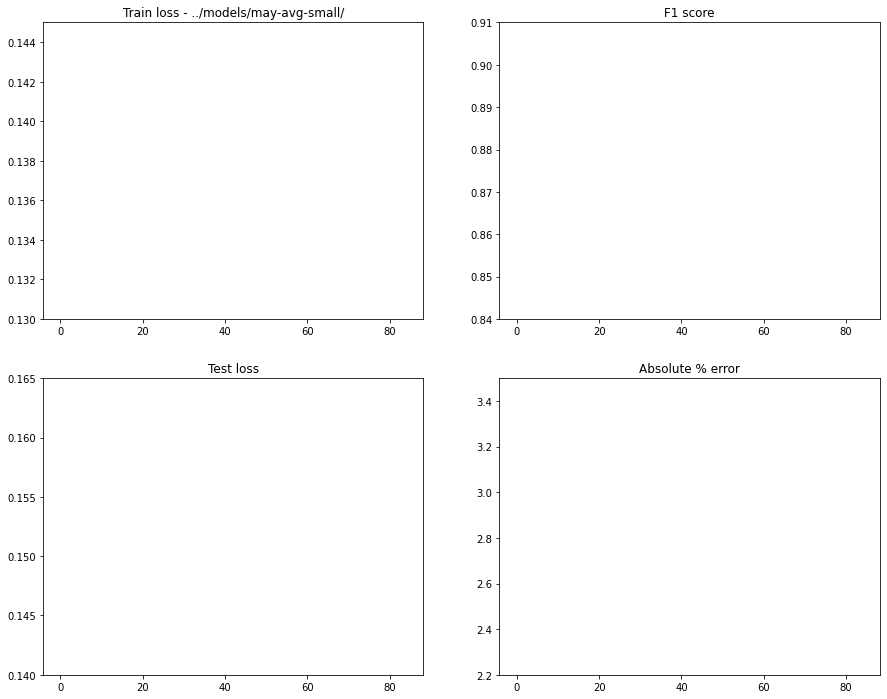

In [31]:
start = 0
end = 85
f, ((c1r1, c1r2), (c2r1, c2r2)) = plt.subplots(2, 2, sharey=False)
f.set_size_inches(15, 12)

c1r1.set_title(f"Train loss - {model_path}")
l1 = sns.scatterplot(y = metrics[0, start:end], x = np.arange(start, end), ax = c1r1)
l1.set(ylim=(0.130, .145))

c1r2.set_title("F1 score")
f =sns.scatterplot(y = metrics[5, start:end], x = np.arange(start, end), ax = c1r2)
f.set(ylim=(0.84, .91))

c2r1.set_title("Test loss")
l = sns.scatterplot(y = metrics[1, start:end], x = np.arange(start, end), ax = c2r1)
l.set(ylim=(0.140, .165)) 

c2r2.set_title("Absolute % error")
e = sns.scatterplot(y = metrics[2, start:end] / 2, x = np.arange(start, end), ax = c2r2)
e.set(ylim=(2.2, 3.5))
plt.show()

In [35]:
import tqdm

best_val = 0.72
fine_tune = False
ft_epochs = 0
BATCH_SIZE = 8



for i in range(1, 30):
    if i >= 30:
        SWA = True# set to true to start SWA
    else:
        SWA = False
    al = FINAL_ALPHA
    #al = np.min([0.01 * (i - 1), FINAL_ALPHA])
    ft_learning_rate = .0001
    be = 0.0
    test_al = al
    op = ft_op# if fine_tune else train_op
        
    train_ids = [x for x in range(len(train_y))]
    #train_ids = train_ids + train_ids[-76:]
    print(len(train_ids))
    #train_ids_cp = (train_ids)
    np.random.shuffle(train_ids)
    randomize = train_ids
    #randomize = equibatch(train_ids, 0)
    print(f"starting epoch {i}, " 
          f"alpha: {al}, beta: {be}, "
          f"drop: {np.max(((1. - (i * 0.005)), 0.9))} "
          f"Learning rate: {ft_learning_rate}"
         )
    
    loss = train_loss
    #test_ids = [x for x in range(0, len(test_x))]
    losses = []
    
    for k in tqdm.notebook.tnrange(int(len(randomize) // BATCH_SIZE)):
        batch_ids = randomize[k*BATCH_SIZE:(k+1)*BATCH_SIZE]
        x_batch, y_batch = augment_batch(batch_ids, BATCH_SIZE)
        #print(np.sum(np.sum(y_batch, axis = (1, 2)) <= 2))
        opt, tr = sess.run([op, loss],
                          feed_dict={inp: x_batch,
                                     length: np.full((BATCH_SIZE,), 12),
                                     labels: y_batch,
                                     is_training: True,
                                     loss_weight: 1.0,
                                     keep_rate: 0.5,#np.max(((1. - (i * 0.01)), MAX_DROPBLOCK)),
                                     alpha: al,
                                     beta_: be,
                                     ft_lr: ft_learning_rate,
                                     })
        losses.append(tr)
    
    print(f"Epoch {i}: Loss {np.around(np.mean(losses[:-1]), 3)}")
    if SWA:
        sess.run(swa_op)
        sess.run(save_weight_backups)
        sess.run(swa_to_weights)
        
    #metrics[0, i] = np.mean(losses[:-1])
    #val_loss, f1, error = calculate_metrics('all', al = test_al, canopy_thresh = 75)
    #metrics[1, i] = val_loss
    #metrics[2, i] = error
    #metrics[5, i] = f1
    
    #if f1 < (best_val - 0.002):
    #    ft_epochs += 1
        
    #if f1 > (best_val - 0.02):
    #    print(f"Saving model with {f1}")
        #np.save(f"{model_path}metrics.npy", metrics)
        #os.mkdir(f"{model_path}{str(i)}-{str(f1*100)[:2]}-{str(f1*100)[3]}/")
        #save_path = saver.save(sess, f"{model_path}/{str(i)}-{str(f1*100)[:2]}-{str(f1*100)[3]}/model")
     #   if f1 > best_val:
     #       best_val = f1
    if SWA:
        sess.run(restore_weight_backups)

112
starting epoch 1, alpha: 0.33, beta: 0.0, drop: 0.995 Learning rate: 0.0001


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 1: Loss 0.26100000739097595
112
starting epoch 2, alpha: 0.33, beta: 0.0, drop: 0.99 Learning rate: 0.0001


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 2: Loss 0.24400000274181366
112
starting epoch 3, alpha: 0.33, beta: 0.0, drop: 0.985 Learning rate: 0.0001


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 3: Loss 0.23999999463558197
112
starting epoch 4, alpha: 0.33, beta: 0.0, drop: 0.98 Learning rate: 0.0001


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 4: Loss 0.23999999463558197
112
starting epoch 5, alpha: 0.33, beta: 0.0, drop: 0.975 Learning rate: 0.0001


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 5: Loss 0.23100000619888306
112
starting epoch 6, alpha: 0.33, beta: 0.0, drop: 0.97 Learning rate: 0.0001


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 6: Loss 0.2290000021457672
112
starting epoch 7, alpha: 0.33, beta: 0.0, drop: 0.965 Learning rate: 0.0001


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 7: Loss 0.22599999606609344
112
starting epoch 8, alpha: 0.33, beta: 0.0, drop: 0.96 Learning rate: 0.0001


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 8: Loss 0.23499999940395355
112
starting epoch 9, alpha: 0.33, beta: 0.0, drop: 0.955 Learning rate: 0.0001


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 9: Loss 0.2150000035762787
112
starting epoch 10, alpha: 0.33, beta: 0.0, drop: 0.95 Learning rate: 0.0001


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 10: Loss 0.2460000067949295
112
starting epoch 11, alpha: 0.33, beta: 0.0, drop: 0.945 Learning rate: 0.0001


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 11: Loss 0.22300000488758087
112
starting epoch 12, alpha: 0.33, beta: 0.0, drop: 0.94 Learning rate: 0.0001


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 12: Loss 0.2280000001192093
112
starting epoch 13, alpha: 0.33, beta: 0.0, drop: 0.935 Learning rate: 0.0001


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 13: Loss 0.23899999260902405
112
starting epoch 14, alpha: 0.33, beta: 0.0, drop: 0.9299999999999999 Learning rate: 0.0001


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 14: Loss 0.22499999403953552
112
starting epoch 15, alpha: 0.33, beta: 0.0, drop: 0.925 Learning rate: 0.0001


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 15: Loss 0.22100000083446503
112
starting epoch 16, alpha: 0.33, beta: 0.0, drop: 0.92 Learning rate: 0.0001


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 16: Loss 0.23499999940395355
112
starting epoch 17, alpha: 0.33, beta: 0.0, drop: 0.915 Learning rate: 0.0001


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 17: Loss 0.2280000001192093
112
starting epoch 18, alpha: 0.33, beta: 0.0, drop: 0.91 Learning rate: 0.0001


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 18: Loss 0.22599999606609344
112
starting epoch 19, alpha: 0.33, beta: 0.0, drop: 0.905 Learning rate: 0.0001


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 19: Loss 0.20200000703334808
112
starting epoch 20, alpha: 0.33, beta: 0.0, drop: 0.9 Learning rate: 0.0001


  0%|          | 0/14 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [36]:
#np.save(f"{model_path}metrics.npy", metrics)
#os.mkdir(f"pineapple-free/")
save_path = saver.save(sess, f"../models/pineapple-free/model")

In [34]:

output_node_names = ['conv2d_13/Sigmoid']
frozen_graph_def = tf.graph_util.convert_variables_to_constants(
    sess,
    sess.graph_def,
    output_node_names)


# Save the frozen graph
with open('../models/pineapple-free/predict_graph.pb', 'wb') as f:
    f.write(frozen_graph_def.SerializeToString())

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-34-f797681687db>", line 5, in <module>
    output_node_names)
  File "/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow_core/python/util/deprecation.py", line 324, in new_func
    return func(*args, **kwargs)
  File "/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow_core/python/framework/graph_util_impl.py", line 277, in convert_variables_to_constants
    inference_graph = extract_sub_graph(input_graph_def, output_node_names)
  File "/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow_core/python/util/deprecation.py", line 324, in new_func
    return func(*args, **kwargs)
  File "/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.

TypeError: object of type 'NoneType' has no len()

# Test prediction visualizations

In [37]:
start = 0
test_ids = [x for x in range(0, len(test_x))]

def multiplot(matrices, nrows = 2, ncols = 4):
    '''Docstring
    
         Parameters:
          matrices (list):
          nrows (int):
          
         Returns:
          None
    '''
    fig, axs = plt.subplots(ncols=4, nrows = nrows)
    fig.set_size_inches(18, 4*nrows)
    to_iter = [[x for x in range(i, i + ncols + 1)] for i in range(0, nrows*ncols, ncols)]
    for r in range(1, nrows + 1):
        min_i = min(to_iter[r-1])
        max_i = max(to_iter[r-1])
        for i, matrix in enumerate(matrices[min_i:max_i]):
            sns.heatmap(data = matrix, ax = axs[r - 1, i], vmin = 0, vmax = 0.9, cbar = False)
            axs[r - 1, i].set_xlabel("")
            axs[r - 1, i].set_ylabel("")
            axs[r - 1, i].set_yticks([])
            axs[r - 1, i].set_xticks([])
    plt.show

In [38]:
test_ids = [x for x in range(test_x.shape[0])]
matrix_ids = np.arange(start, start + 8, 1)
matrix_ids = test_ids[matrix_ids]
preds, trues = [], []

for i in matrix_ids:
    idx = i
    x_input = test_x[idx].reshape(1, 13, 28, 28, n_bands)
    median_input = calc_median_input(x_input)
    y = sess.run([fm], feed_dict={inp: x_input,
                                  length: np.full((1,), 12),
                                  is_training: False,
                                  })
    y = np.array(y).reshape(14, 14)
    print(i, (list(test_data.iloc[idx, 1])[0], list(test_data.iloc[idx, 2])[0]), diffs[i[0]])
    preds.append(y)
    y2 = np.copy(y)
    true = test_y[idx].reshape(14, 14)
    trues.append(true)

to_plot = trues[0:4] + preds[0:4] + trues[4:] + preds[4:]
multiplot(to_plot, nrows = 4, ncols = 4)

start = start + 8 

TypeError: only integer scalar arrays can be converted to a scalar index

# Train prediction visualizations

In [39]:
start = 0

[64 65 66 67 68 69 70 71]


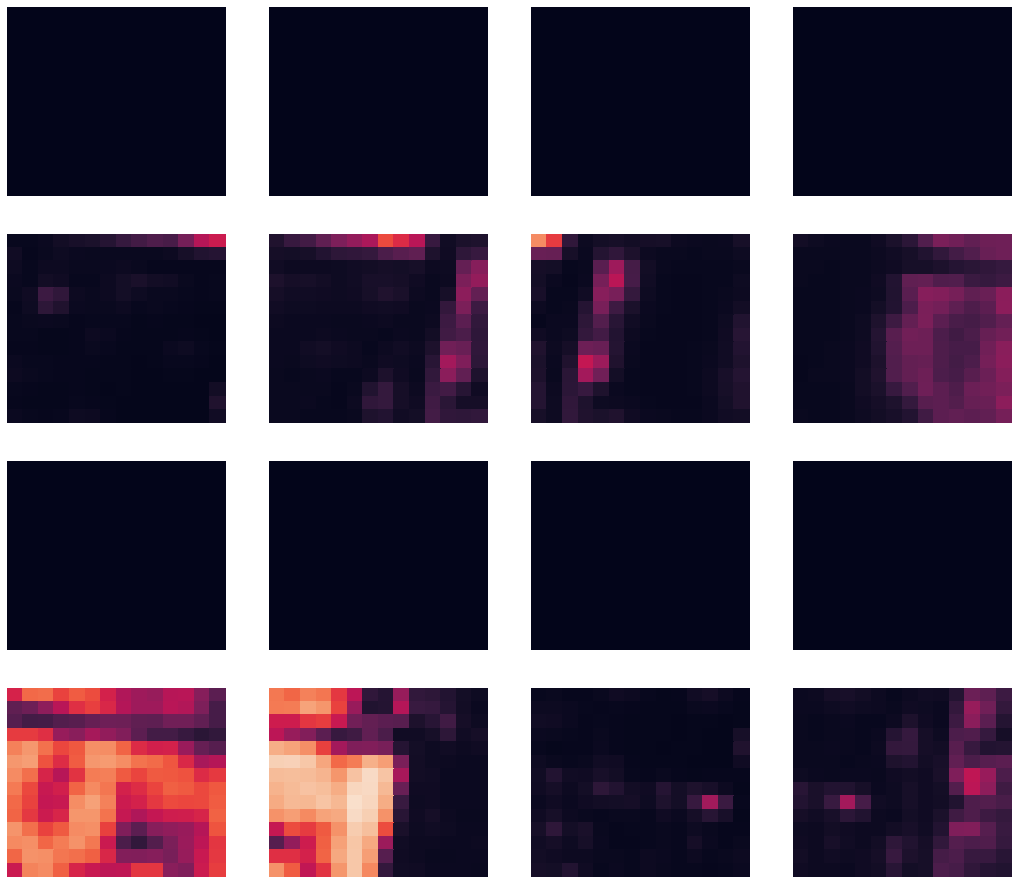

In [48]:
train_ids = np.array([x for x in range(train_x.shape[0])])
#start = len(train_ids) - 84

matrix_ids = np.arange(start, start + 8, 1)
matrix_ids = train_ids[matrix_ids]
preds, trues = [], []

print(matrix_ids)
for i in matrix_ids:
    idx = i
    x_input = train_x[idx].reshape(1, 13, 28, 28, n_bands)
    y = sess.run([fm], feed_dict={inp: x_input,
                                  length: np.full((1,), 12),
                                  is_training: False,
                                    })
    y = np.array(y).reshape(14, 14)    
    preds.append(y)
    true = train_y[idx].reshape(14, 14)
    trues.append(true)
    
start += 8
to_plot = trues[0:4] + preds[0:4] + trues[4:] + preds[4:]
multiplot(to_plot, nrows = 4, ncols = 4)

In [ ]:
train_ids = np.array([x for x in range(train_x.shape[0])])
start = 1297

matrix_ids = np.arange(start, start + 8, 1)
matrix_ids = train_ids[matrix_ids]
preds, trues = [], []

print(matrix_ids)
for i in matrix_ids:
    idx = i
    x_input = train_x[idx].reshape(1, 13, 28, 28, n_bands)
    y = sess.run([fm], feed_dict={inp: x_input,
                                  length: np.full((1,), 12),
                                  is_training: False,
                                    })
    y = np.array(y).reshape(14, 14)    
    preds.append(y)
    true = train_y[idx].reshape(14, 14)
    trues.append(true)
    
start += 8
to_plot = trues[0:4] + preds[0:4] + trues[4:] + preds[4:]
multiplot(to_plot, nrows = 4, ncols = 4)

In [ ]:
gru.trainable